In [1]:
#print(1)

In [2]:
#%%capture
#!pip install biopython
#!pip install tensorflow-addons
#!pip install tensorflow

In [3]:
import pandas as pd
import Bio
from Bio.Seq import Seq
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow.keras.layers as L
import keras.backend as K
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
from sklearn.cluster import KMeans
from Bio import SeqIO
from Bio.Seq import Seq
from joblib import Parallel, delayed
import os
import gc
import random
from tensorflow.keras.callbacks import TerminateOnNaN
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import Callback

In [4]:
import multiprocessing
multiprocessing.cpu_count()

128

In [5]:
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    #os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    #tf.config.threading.set_inter_op_parallelism_threads(1)
    #tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_seeds(seed=42)
set_global_determinism(seed=42)

In [6]:
num_threads = 2
# Maximum number of threads to use for OpenMP parallel regions.
os.environ["OMP_NUM_THREADS"] = str(num_threads)
# Without setting below 2 environment variables, it didn't work for me. Thanks to @cjw85 
os.environ["TF_NUM_INTRAOP_THREADS"] = str(num_threads)
os.environ["TF_NUM_INTEROP_THREADS"] = str(num_threads)

tf.config.threading.set_inter_op_parallelism_threads(
    num_threads
)
tf.config.threading.set_intra_op_parallelism_threads(
    num_threads
)
tf.config.set_soft_device_placement(True)

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0.001, 0.999))

In [11]:
#get some stats for the train set and transform y
train = pd.read_csv('train_sequences.txt',header=None,sep='\t')
train.columns = ['seq','target']
scaler.fit(train[['target']])

print(train.shape)
#train=train[train.seq.str.len()==110]
max_seq_len = train.seq.str.len().max()
target_mean = train.target.mean()
target_std = train.target.std()

train['target']=scaler.transform(train[['target']])
train.head()

(6739258, 2)


,seq,target
0,TGCATTTTTTTCACATCTCTTTGCCACGGGGTGAAGGATAGGATGG...,0.646765
1,TGCATTTTTTTCACATCTATGTTGCGTTAGAACGATATTGGAACAC...,0.353235
2,TGCATTTTTTTCACATCTGTGAAGAATATCAGCTTTCAATCGTATT...,0.470647
3,TGCATTTTTTTCACATCAATCCGAGATATCTGTTGATAAACTTACC...,0.529353
4,TGCATTTTTTTCACATCAAGTTATCTGGTGTACGTTTTCTCGTATA...,0.705471


In [13]:
#set apart 10000 promoters for test set
X_test = train.sample(n=10000, random_state=42)
X_test=X_test.reset_index(drop=True)
print(X_test.shape)
X_test.head()

(10000, 2)


,seq,target
0,TGCATTTTTTTCACATCCGTGACTTTGTCAGTCCCGTGTGCCGCAG...,0.869883
1,TGCATTTTTTTCACATCGTTATTGGGCGAGGTGAGGCATCCATTGT...,0.764176
2,TGCATTTTTTTCACATCTACCCTGCTTATTATCCTCTAGAATTAGA...,0.529353
3,TGCATTTTTTTCACATCATATTGTGTAGTCACATCGCAATAGGTTT...,0.129245
4,TGCATTTTTTTCACATCCTTATCTGTAGAGATAAGTTATCGTCGCT...,0.705471


In [14]:
#remove from train set the test set
print(train.shape)
train = train[~train.index.isin(X_test.index)]
train=train.reset_index(drop=True)
print(train.shape)
train.head()

(6739258, 2)
(6729258, 2)


,seq,target
0,TGCATTTTTTTCACATCTTTCTTTACAGGGAAGTTTGGTTTTTGAA...,0.822882
1,TGCATTTTTTTCACATCAGGTCCAGCTAGATTAGAAATGTTGTTCT...,0.646765
2,TGCATTTTTTTCACATCTCTCTTATGTATAAAGACTCGATGATTAG...,0.588059
3,TGCATTTTTTTCACATCGTCTAGGCTTATTTTCTTGAGTCTATTTG...,0.776059
4,TGCATTTTTTTCACATCTGGTCAAGCTTCCGATGTCAAATTTTGTG...,0.646765


In [15]:
#prepare the sequences to predict
X_predict = pd.read_csv('test_sequences.txt',header=None,sep='\t')
X_predict.columns = ['seq','target']
X_predict.head()

,seq,target
0,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAAAAACTAGCA...,NaN
1,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAGAAAACGAGC...,NaN
2,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAGAAAACGAGC...,NaN
3,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAGAAAACGAGC...,NaN
4,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAGAAAACGAGC...,NaN


In [17]:
#this assigment is not necessary but here for hystorical reasons....
X_train = train
y_train = train['target']

In [18]:
X_train.shape,X_test.shape

((6729258, 2), (10000, 2))

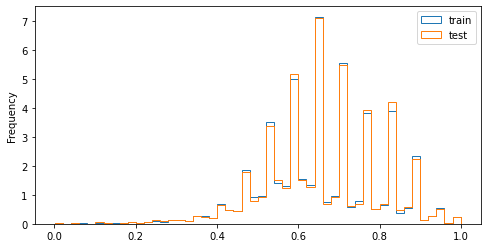

In [19]:
#check distribution of train and test set
fig,ax=plt.subplots(figsize=(8,4))
X_train['target'].plot(ax=ax,kind='hist',histtype='step',label='train',density=True,bins=50)
X_test['target'].plot(ax=ax,kind='hist',histtype='step',label='test',density=True,bins=50)
plt.legend()

In [20]:
#tis function adds some padding for the shorter sequences
def pad_sequence(X):
    pad_length = max_seq_len-len(X)
    return X+''.join(['P']*pad_length)

#this function makes the complement of a dna sequences
def to_complement(X):
    dict_complement = {
        'A':'T',
        'T':'A',
        'G':'C',
        'C':'G',
        'P':'P',
        'N':'N',
    }
    return ''.join([dict_complement[n] for n in X])

#one hot encoding of the dna
def return_ohe(n, i):
    tmp = [0] * n
    tmp[i] = 1
    return tmp

#this function encode train data
#it is applaied in batches during training
#rather then to the full dataset
def get_input(train, random_select='yes'):
    #padding to the longest sequence in train
    train.loc[:, "seq"]=train["seq"].apply(pad_sequence)
    #add the reverse-complement strand
    train.loc[:, "rc_seq"] = train["seq"].apply(to_complement)
    ## get node features, which is one hot encoded
    #print(train.head())
    mapping = {}
    vocab = ["A", "G", "C", "T", "N", "P"]
    for i, s in enumerate(vocab):
        mapping[s] = return_ohe(len(vocab), i)
    #print(mapping)
    #encoding the forward
    X_node = np.stack(train["seq"].apply(lambda x : list(map(lambda y : mapping[y], list(x)))))
    #encoding the reverse compleent
    X_node_rc = np.stack(train["rc_seq"].apply(lambda x : list(map(lambda y : mapping[y], list(x)))))

    #concatenate, forward first
    X_node_1 = np.concatenate([X_node, X_node_rc], axis = 2).astype(np.float32) 
    
    #concatenate, reverse complement first
    X_node_2 = np.concatenate([X_node_rc, X_node], axis = 2).astype(np.float32)
      #print(X_node.shape)

    #return randomly forward first or reverse complement first
    #this was to experiment different way of training
    #final submission uses the forward first
    if random_select == 'yes':
        select = np.random.choice([0, 1])
    else:
        select=random_select
    
    if select == 1:
        #return  forward first
        return X_node_1
    else:
        #return reverse complement first
        return X_node_2


    #return np.concatenate([X_node_1, X_node_2], axis = 1)


In [21]:
#https://github.com/WenYanger/Keras_Metrics/blob/master/PearsonCorr.py
from keras import backend as K
def pearson_r(y_true, y_pred):
    #print(y_true,y_pred)
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.sum(xm * ym)
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = K.sqrt(x_square_sum * y_square_sum)
    r = r_num / r_den
    return K.mean(r)

In [22]:
#first time to use a data loader, saving some useful ref

#https://datascience.stackexchange.com/questions/47623/how-feed-a-numpy-array-in-batches-in-keras
#https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
#https://pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
#https://datascience.stackexchange.com/questions/47623/how-feed-a-numpy-array-in-batches-in-keras
#https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3
#https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
#https://numpy.org/doc/stable/reference/generated/numpy.array_split.html#numpy.array_split

#The dataset loader grabs batches of data from the panda df
#It pads sequences and apply one-hot encoding to forward and reverse strand.

#The dataset is initialised with the number of batches that it shuld use and
#figures out the number of samples in each batch using array_split from numpy

from tensorflow.keras.utils import Sequence
class DataGenerator(Sequence):
    def __init__(self, x_data, num_batches=4500, shuffle=True, target_col='target', random_select='yes'):

        self.data = x_data
        #store the index of the df in array
        self.indexes = np.array(self.data.index.values)
        self.num_batches = num_batches
        
        #array_split distribute the data into the batches
        #if the num_batches is not divisible by the length
        #of the df, the batches will have sligtly different
        #number of items
        self.batches = np.array_split(self.indexes, self.num_batches)
        

        #it is good practice to shuffle the data between epochs
        #but you do not want to shuffle for prediction
        self.shuffle = shuffle
        self.target_col = target_col
        self.random_select = random_select
    
    def __len__(self):
        #must be defined as the number
        #of batches
        return self.num_batches
    
    def __getitem__(self, idx):
        #must be defined to return one batch of data
        batch_x = self.data.loc[self.batches[idx],:]

        batch_y = batch_x[self.target_col]
      
        #get_input makes the feature extraction
        x_trn = get_input(batch_x, random_select = self.random_select)
        return x_trn, batch_y.values
    
    def on_epoch_end(self):
        #shuffle all data every epoch end
        if self.shuffle:
            np.random.shuffle(self.indexes)
            self.batches = np.array_split(self.indexes, self.num_batches)
            
    def on_epoch_start(self):
        #shuffle all data every epoch start
        if self.shuffle:
            np.random.shuffle(self.indexes)
            self.batches = np.array_split(self.indexes, self.num_batches)


In [23]:
num_batches=3700
train_generator = DataGenerator(X_train, num_batches = num_batches, shuffle=True, random_select=1)
test_generator = DataGenerator(X_test, num_batches = 5, random_select=1)
predict_generator = DataGenerator(X_predict, num_batches = num_batches, random_select=1) 

In [24]:
len(train_generator.batches[0])

1819

In [27]:
X_train.loc[train_generator.batches[0]]

,seq,target
0,TGCATTTTTTTCACATCTTTCTTTACAGGGAAGTTTGGTTTTTGAA...,0.822882
1,TGCATTTTTTTCACATCAGGTCCAGCTAGATTAGAAATGTTGTTCT...,0.646765
2,TGCATTTTTTTCACATCTCTCTTATGTATAAAGACTCGATGATTAG...,0.588059
3,TGCATTTTTTTCACATCGTCTAGGCTTATTTTCTTGAGTCTATTTG...,0.776059
4,TGCATTTTTTTCACATCTGGTCAAGCTTCCGATGTCAAATTTTGTG...,0.646765
...,...,...
1814,TGCATTTTTTTCACATCGTCAAGTGTGTTCTTCGCCCGGCGGGGAT...,0.881588
1815,TGCATTTTTTTCACATCGTTCAAGTGTCGGGACTGTCAGATTTAGT...,0.881588
1816,TGCATTTTTTTCACATCGCAACCTGTTTTTTGTGGGGTTCCCTCGC...,0.588059
1817,TGCATTTTTTTCACATCGTTTTAAGAGGATTCGAGAAACCACAGAG...,0.759040


In [28]:
test_generator.batches[0]

array([   0,    1,    2, ..., 1997, 1998, 1999])

In [30]:
#visualize shape of train gen
import warnings
warnings.filterwarnings("ignore")
t = train_generator[0]
t[0].shape,t[1].shape

((1819, 142, 12), (1819,))

In [31]:
def rmse(y_actual, y_pred):
    mse = tf.keras.losses.mean_squared_error(y_actual, y_pred)
    return K.sqrt(mse)


#a shortcut for a Bidirectional GRU layer
def gru_layer(hidden_dim=256, dropout=0.1):
    return layers.Bidirectional(layers.GRU(hidden_dim, 
                                 dropout=dropout, 
                                 return_sequences=True, 
                                 kernel_initializer = 'orthogonal',
                                 bias_initializer='orthogonal'
                                ))

In [32]:
#The actual model
#two Bidirectional GRUs followed by CONVs and fully connected 

def build_model(
    input_shape,
    gru_hidden_dim=64,
    mlp_units=[512, 32],
    do_conv=True,    
    kernel_size1=6,
    kernel_size2=3,
    kernel_size3=3,
    pool_size1=3,
    pool_size2=3,
    filters1=256,
    filters2=128,
    filters3=64):
    
    inputs = keras.Input(shape=input_shape)
    
    
    x = inputs
    
    x = gru_layer(hidden_dim=gru_hidden_dim,dropout=0)(x)
    x = gru_layer(hidden_dim=gru_hidden_dim,dropout=0)(x)
    
    if do_conv:
        x = layers.Conv1D(filters=filters1, kernel_size=kernel_size1, activation='LeakyReLU')(x)
        x = layers.MaxPooling1D(pool_size=pool_size1)(x)
        x = layers.Conv1D(filters=filters2, kernel_size=kernel_size2, activation='LeakyReLU')(x)
        x = layers.MaxPooling1D(pool_size=pool_size2)(x)
        x = layers.Conv1D(filters=filters3, kernel_size=kernel_size3, activation='LeakyReLU')(x)
    else:
        x = layers.Conv1D(filters=filters1, kernel_size=kernel_size1, activation='LeakyReLU')(x)
    
    x = layers.Flatten()(x)
    
    for dim in mlp_units:
        x = layers.Dense(dim)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return keras.Model(inputs, outputs)

In [33]:
def coeff_det(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [34]:
#11 PearsonR² 0.919 Spearman 0.962 ScorePearsonR² 0.745 ScoreSpearman 0.802
config={
    'gru_hidden_dim':256,
    'mlp_units':[512, 32],
    'do_conv': True,    
    'kernel_size1':6,
    'kernel_size2':3,
    'kernel_size3':3,
    'pool_size1':3,
    'pool_size2':2,
    'filters1':256,
    'filters2':128,
    'filters3':64    
    
 }

In [35]:
for n in train_generator:
    input_shape = n[0].shape[1:]
    break

model_name = 'sub_model'

model = build_model(
    input_shape=input_shape,
    **config   
)
mae = tf.keras.losses.MeanAbsoluteError()

#binary crossentropy is used with the sigmoid activation on the output layer
bc = tf.keras.losses.BinaryCrossentropy()


model.compile(
    loss=bc, 
    optimizer=keras.optimizers.Adam(epsilon=1e-6, global_clipnorm=1.0),
    metrics=[pearson_r, coeff_det],
)
model.summary()

2022-07-26 21:06:02.128339: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-26 21:06:02.821959: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43648 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:81:00.0, compute capability: 8.6


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 142, 12)]         0         
                                                                 
 bidirectional (Bidirectiona  (None, 142, 512)         414720    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 142, 512)         1182720   
 nal)                                                            
                                                                 
 conv1d (Conv1D)             (None, 137, 256)          786688    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 45, 256)          0         
 )                                                               
                                                             

In [37]:

#set the final number of batches
num_batches=6700
train_generator = DataGenerator(X_train, num_batches = num_batches, shuffle=True, random_select=1)
test_generator = DataGenerator(X_test, num_batches = 5, random_select=1)
predict_generator = DataGenerator(X_predict, num_batches = num_batches, random_select=1) 

In [38]:
#this code train one epoch at time and save the weights
#the EarlyStopping and TerminateOnNaN are not necessary
#but still here for hystorical reasons
verbosity = 1
for epoch in range(1, 12):
    
    callbacks=[
        
                #tf.keras.callbacks.ReduceLROnPlateau(),
                #tf.keras.callbacks.ReduceLROnPlateau(patience = 3, factor = 0.25, min_lr = 1e-06,
                #                                     verbose = 1, monitor='val_pearson_r',mode='max'),
                tf.keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True,  
                                                 monitor='val_pearson_r', mode='max'),
                tf.keras.callbacks.ModelCheckpoint(model_name+'.{epoch}.h5'.format(epoch=epoch), save_best_only=True,
                                                   mode='max', monitor='val_pearson_r'),
                tf.keras.callbacks.TerminateOnNaN()]
    
    if epoch >1:
        model = tf.keras.models.load_model(model_name+'.{epoch}.h5'.format(epoch=epoch-1), custom_objects={'rmse': rmse,'pearson_r':pearson_r,'coeff_det':coeff_det})

    model.fit(train_generator, validation_data=test_generator, epochs=1, verbose=verbosity, callbacks=callbacks)


2022-07-26 21:06:10.836246: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-07-26 21:06:15.378784: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


6700/6700 [==============================] - 2655s 396ms/step - loss: 0.6181 - pearson_r: 0.7634 - coeff_det: 0.5812 - val_loss: 0.6164 - val_pearson_r: 0.7698 - val_coeff_det: 0.5876


make prediction using:  sub_model.11.h5
shape: (71103, 1) (71103, 2)
                                                 seq     preds
0  TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAAAAACTAGCA...  0.708024
1  TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAGAAAACGAGC...  0.709611
2  TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAGAAAACGAGC...  0.699942
3  TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAGAAAACGAGC...  0.692968
4  TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAGAAAACGAGC...  0.742253
done


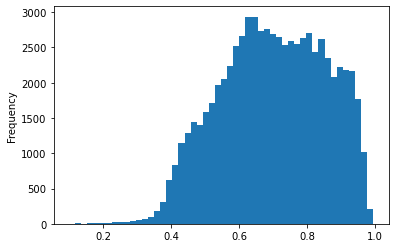

In [39]:
#this code loads a model and create predictions
#it also transfor the predictions into the 
#format for submission.

import json
import numpy as np
import pandas as pd
from collections import OrderedDict

def make_prediction(model_id, model_name, is_class = False):
    print('make prediction using: ', model_name+'.{model_id}.h5'.format(model_id=model_id))
    model = tf.keras.models.load_model(
        model_name+'.{model_id}.h5'.format(model_id=model_id),custom_objects={
    'rmse': rmse,'pearson_r':pearson_r,'coeff_det':coeff_det})
    predict_generator_1 = DataGenerator(X_predict, num_batches = 10000, random_select=1, shuffle=False) 
    out_1 = model.predict(predict_generator_1)
    print('shape:', out_1.shape, X_predict.shape)
    if is_class:
        #trained a classification once, then dropped the idea
        X_predict['preds_1'] = np.argmax(out_1,axis=1).squeeze()
    else:
        X_predict['preds_1'] = out_1.max(axis=1).squeeze()
    X_predict['preds_1'].plot(kind='hist',bins=50)
    X_predict['preds']=X_predict['preds_1']
    
    X_predict[['seq','preds']].to_csv(
        model_name+'.{model_id}.csv'.format(model_id=model_id),
        header=False,index=False,sep='\t') 
    
    with open('sample_submission.json', 'r') as f:
        ground=json.load(f)
    indices=np.array([int(indice) for indice in list(ground.keys())])

    df_pred = pd.read_csv(model_name+'.{model_id}.csv'.format(model_id=model_id), sep='\t',header=None)
    df_pred.columns = ['seq','preds']

    Y_pred=df_pred.preds.values
    print(df_pred.head())
    PRED_DATA = OrderedDict()
    for i in indices:
        PRED_DATA[str(i)]= float(Y_pred[i])

    def dump(pred_dict, pred_file):
        with open(pred_file, 'w') as f:
            json.dump(pred_dict, f)
    dump(PRED_DATA,model_name+'.{model_id}.csv.json'.format(model_id=model_id)) 
    print('done')
    
#select the epoch and predict
make_prediction(11, model_name=model_name)

In [41]:
#outs from leaderbord 
#11 PearsonR² 0.919 Spearman 0.962 ScorePearsonR² 0.745 ScoreSpearman 0.802 *
#10 PearsonR² 0.911 Spearman 0.960 ScorePearsonR² 0.729 ScoreSpearman 0.792

In [42]:
#using this code to save the version of the used packages
#https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        #print(name)
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL":     "Pillow",
            "sklearn": "scikit-learn",
            "Bio":     "biopython",
            "tensorflow_addons":"tensorflow-addons"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

tqdm==4.64.0
matplotlib==3.5.1
tensorflow==2.7.0
keras==2.7.0
biopython==1.79
numpy==1.22.3
pandas==1.4.2
joblib==1.1.0
scikit-learn==1.0.2
tensorflow-addons==0.16.1


In [44]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/homes/mtinti/miniconda3/envs/proteinBert2/bin/python
3.10.4 | packaged by conda-forge | (main, Mar 24 2022, 17:38:57) [GCC 10.3.0]
sys.version_info(major=3, minor=10, micro=4, releaselevel='final', serial=0)
